
# Project 2: Data Preparation

**How to run:** Python 3.10+, `pip install -r requirements.txt`  
**Dataset:** `/data/project/MSA8395/mapillary_traffic_sign_dataset`  
**Outputs:** `results/figures/`


In [20]:
# === Block 4D: Run evaluation on VAL & TEST; show a visual ===
import matplotlib.pyplot as plt

print("=== Region Proposal Evaluation — VAL (tuned) ===")
eval_region_proposal(ann_val, thresholds=(0.3,0.5,0.7), max_images=60, verbose_every=10)

print("\n=== Region Proposal Evaluation — TEST (tuned) ===")
eval_region_proposal(ann_test, thresholds=(0.3,0.5,0.7), max_images=60, verbose_every=10)

# (Optional) 2-image qualitative check
def _draw_box(img, box, color=(0,255,0), t=2):
    if box is None: return
    H,W=img.shape[:2]
    x,y,w,h = int(box[0]),int(box[1]),int(box[2]),int(box[3])
    x=max(0,min(x,W-1)); y=max(0,min(y,H-1))
    w=max(1,min(w,W-x)); h=max(1,min(h,H-y))
    cv2.rectangle(img,(x,y),(x+w,y+h),color,t)

def show_tuned_examples(df_ann, n=2, topN=15):
    imgs = df_ann["image_path"].drop_duplicates().sample(n=min(n, df_ann["image_path"].nunique()), random_state=42)
    for p in imgs:
        bgr = cv2.imread(p)
        if bgr is None: continue
        props = propose_regions(bgr, topN=topN)
        vis = bgr.copy()
        # GT green
        for _,r in df_ann[df_ann["image_path"]==p].iterrows():
            _draw_box(vis,(r["x"],r["y"],r["w"],r["h"]),(0,255,0),2)
        # proposals red
        for box in props:
            _draw_box(vis,box,(0,0,255),2)
        plt.figure(figsize=(7,7))
        plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)); plt.axis("off")
        plt.title(f"TUNED — GT(green) vs Props(red) — {len(props)} (topN={topN})")
        plt.show()

# show_tuned_examples(ann_val, n=2, topN=15)


=== Region Proposal Evaluation — VAL (tuned) ===
[10/60] avg props/img 14.0
[20/60] avg props/img 13.7
[30/60] avg props/img 13.7
[40/60] avg props/img 13.8
[50/60] avg props/img 13.8
[60/60] avg props/img 13.9

Evaluated 60 images in 5.9s
Avg proposals/img: 13.90 | Avg GT/img: 3.10
IoU ≥ 0.3 → Precision 0.014 | Recall 0.065 | F1 0.024 (TP=12, FP=822, FN=174)
IoU ≥ 0.5 → Precision 0.008 | Recall 0.038 | F1 0.014 (TP=7, FP=827, FN=179)
IoU ≥ 0.7 → Precision 0.004 | Recall 0.016 | F1 0.006 (TP=3, FP=831, FN=183)

=== Region Proposal Evaluation — TEST (tuned) ===
[10/60] avg props/img 13.9
[20/60] avg props/img 13.8
[30/60] avg props/img 14.2
[40/60] avg props/img 14.3
[50/60] avg props/img 14.4
[60/60] avg props/img 14.5

Evaluated 60 images in 6.4s
Avg proposals/img: 14.50 | Avg GT/img: 3.10
IoU ≥ 0.3 → Precision 0.008 | Recall 0.038 | F1 0.013 (TP=7, FP=863, FN=179)
IoU ≥ 0.5 → Precision 0.007 | Recall 0.032 | F1 0.011 (TP=6, FP=864, FN=180)
IoU ≥ 0.7 → Precision 0.006 | Recall 0.027 |

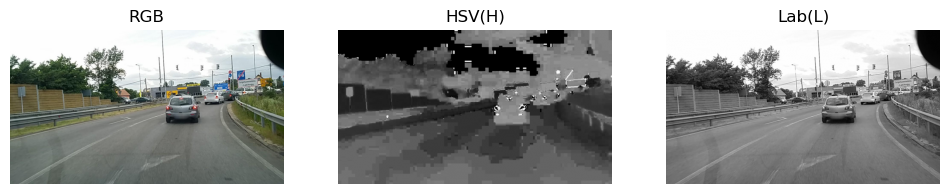

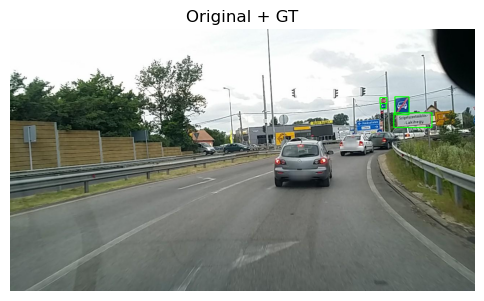

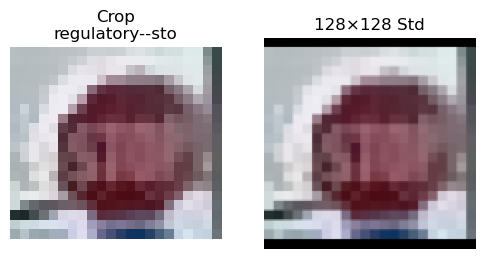

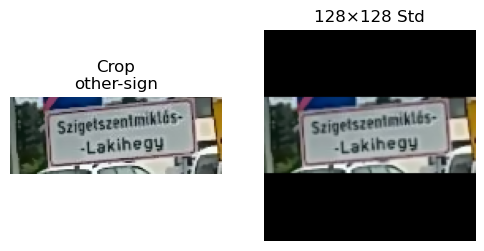

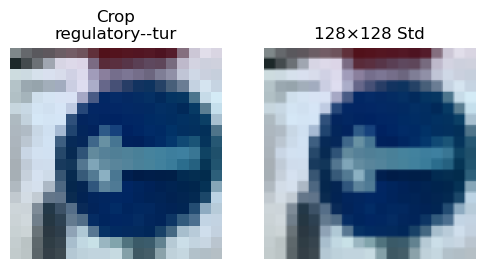

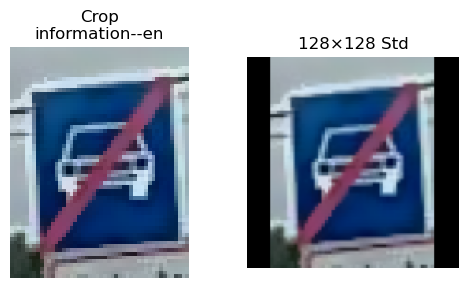

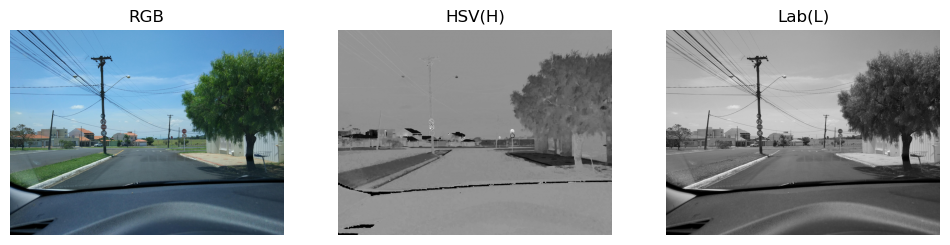

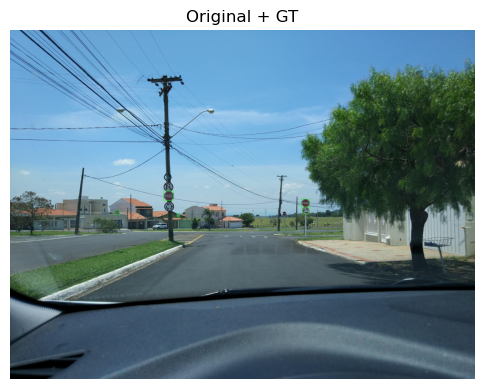

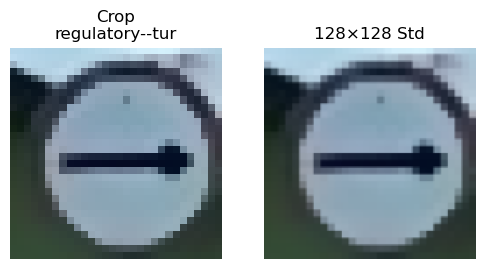

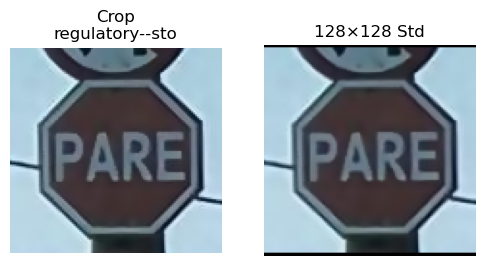

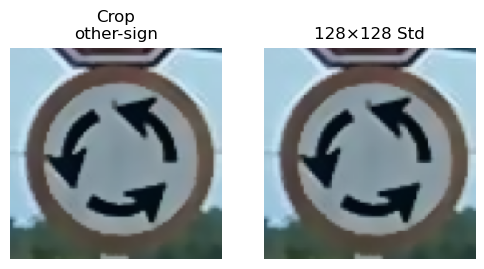

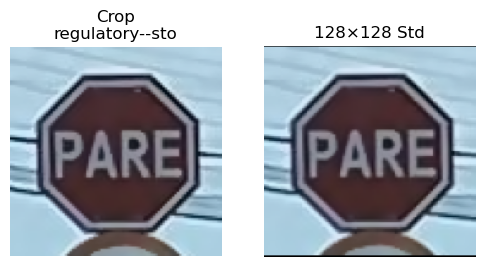

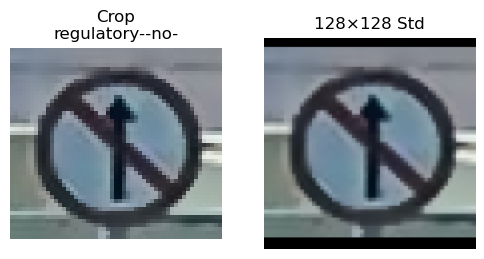

In [23]:
# ====== Phase 1 — Part B: Preprocessing pipeline ======
import cv2, numpy as np, matplotlib.pyplot as plt

def to_rgb(img): return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def enhance_image(bgr):
    lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2Lab)
    L,a,b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    L2 = clahe.apply(L)
    lab2 = cv2.merge([L2,a,b])
    bgr2 = cv2.cvtColor(lab2, cv2.COLOR_Lab2BGR)
    return cv2.bilateralFilter(bgr2, d=7, sigmaColor=60, sigmaSpace=60)

def extract_and_standardize(bgr, rows_df, pad_ratio=0.15, out_size=128, enhance=True):
    if enhance: bgr = enhance_image(bgr)
    H,W = bgr.shape[:2]; out=[]
    for _, r in rows_df.iterrows():
        x,y,w,h = int(r["x"]),int(r["y"]),int(r["w"]),int(r["h"])
        px,py=int(w*pad_ratio),int(h*pad_ratio)
        x1,y1=max(0,x-px),max(0,y-py); x2,y2=min(W,x+w+px),min(H,y+h+py)
        crop=bgr[y1:y2,x1:x2]
        if crop.size==0: continue
        ch,cw=crop.shape[:2]; scale=out_size/max(ch,cw)
        resized=cv2.resize(crop,(int(cw*scale),int(ch*scale)),interpolation=cv2.INTER_AREA)
        pad_t=(out_size-resized.shape[0])//2; pad_b=out_size-resized.shape[0]-pad_t
        pad_l=(out_size-resized.shape[1])//2; pad_r=out_size-resized.shape[1]-pad_l
        standardized=cv2.copyMakeBorder(resized,pad_t,pad_b,pad_l,pad_r,cv2.BORDER_CONSTANT,value=(0,0,0))
        out.append((crop,standardized,r["label"]))
    return out

def show_color_spaces_and_crops(df_ann, n_images=2, max_signs_per_image=5, enhance=True):
    imgs=df_ann["image_path"].drop_duplicates().sample(n=min(n_images,df_ann["image_path"].nunique()),random_state=42)
    for p in imgs:
        bgr=cv2.imread(p); 
        if bgr is None: continue
        hsv=cv2.cvtColor(bgr,cv2.COLOR_BGR2HSV); lab=cv2.cvtColor(bgr,cv2.COLOR_BGR2Lab)
        fig,ax=plt.subplots(1,3,figsize=(12,4))
        ax[0].imshow(to_rgb(bgr));ax[0].set_title("RGB");ax[0].axis('off')
        ax[1].imshow(hsv[:,:,0],cmap='gray');ax[1].set_title("HSV(H)");ax[1].axis('off')
        ax[2].imshow(lab[:,:,0],cmap='gray');ax[2].set_title("Lab(L)");ax[2].axis('off')
        plt.show()
        rows=df_ann[df_ann["image_path"]==p].head(max_signs_per_image)
        crops=extract_and_standardize(bgr,rows,enhance=enhance)
        vis=bgr.copy()
        for _,r in rows.iterrows():
            cv2.rectangle(vis,(int(r["x"]),int(r["y"])),(int(r["x"]+r["w"]),int(r["y"]+r["h"])),(0,255,0),2)
        plt.figure(figsize=(6,6));plt.imshow(to_rgb(vis));plt.axis('off');plt.title("Original + GT");plt.show()
        for crop,std,lab_ in crops:
            fig,ax=plt.subplots(1,2,figsize=(6,3))
            ax[0].imshow(to_rgb(crop));ax[0].set_title(f"Crop\n{lab_[:15]}");ax[0].axis('off')
            ax[1].imshow(to_rgb(std));ax[1].set_title("128×128 Std");ax[1].axis('off')
            plt.show()

show_color_spaces_and_crops(ann_train, n_images=2, enhance=True)


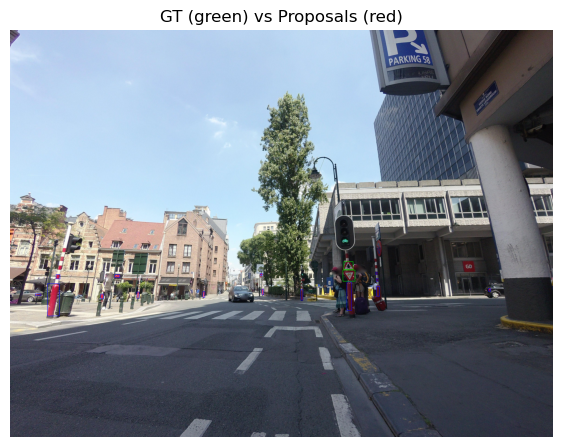

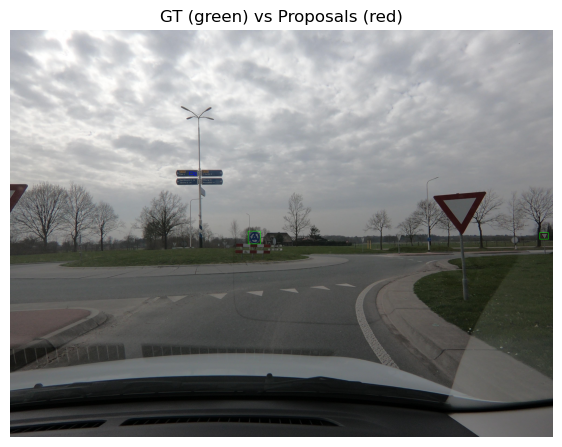

=== VAL ===
IoU ≥ 0.3 → Precision 0.050 | Recall 0.200 | F1 0.081 (TP=17, FP=320, FN=68)
IoU ≥ 0.5 → Precision 0.045 | Recall 0.176 | F1 0.071 (TP=15, FP=322, FN=70)
IoU ≥ 0.7 → Precision 0.027 | Recall 0.106 | F1 0.043 (TP=9, FP=328, FN=76)

=== TEST ===
IoU ≥ 0.3 → Precision 0.045 | Recall 0.217 | F1 0.075 (TP=18, FP=381, FN=65)
IoU ≥ 0.5 → Precision 0.033 | Recall 0.157 | F1 0.054 (TP=13, FP=386, FN=70)
IoU ≥ 0.7 → Precision 0.023 | Recall 0.108 | F1 0.037 (TP=9, FP=390, FN=74)


In [24]:
# ====== Phase 1 — Part C: Region proposals + evaluation ======
import time

def _color_masks_hsv_strict(bgr):
    hsv=cv2.cvtColor(bgr,cv2.COLOR_BGR2HSV)
    mr=cv2.inRange(hsv,(0,110,80),(10,255,255))|cv2.inRange(hsv,(170,110,80),(180,255,255))
    mb=cv2.inRange(hsv,(100,120,70),(130,255,255))
    my=cv2.inRange(hsv,(15,140,90),(35,255,255))
    return mr,mb,my

def _morph(mask,o=3,c=5):
    k1=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(o,o));k2=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(c,c))
    return cv2.morphologyEx(cv2.morphologyEx(mask,cv2.MORPH_OPEN,k1),cv2.MORPH_CLOSE,k2)

def _boxes_from_mask(mask,W,H):
    cnts,_=cv2.findContours(mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    return [cv2.boundingRect(c) for c in cnts if cv2.contourArea(c)>100]

def propose_regions(bgr, topN=15):
    H,W=bgr.shape[:2]
    mr,mb,my=_color_masks_hsv_strict(bgr)
    mr,mb,my=_morph(mr),_morph(mb),_morph(my)
    boxes=_boxes_from_mask(mr,W,H)+_boxes_from_mask(mb,W,H)+_boxes_from_mask(my,W,H)
    return boxes[:topN]

def show_proposals_inline(df_ann,n=2):
    imgs=df_ann["image_path"].drop_duplicates().sample(n=min(n,df_ann["image_path"].nunique()),random_state=42)
    for p in imgs:
        bgr=cv2.imread(p)
        if bgr is None: continue
        props=propose_regions(bgr)
        vis=bgr.copy()
        for _,r in df_ann[df_ann["image_path"]==p].iterrows():
            cv2.rectangle(vis,(int(r["x"]),int(r["y"])),(int(r["x"]+r["w"]),int(r["y"]+r["h"])),(0,255,0),2)
        for (x,y,w,h) in props:
            cv2.rectangle(vis,(x,y),(x+w,y+h),(255,0,0),2)
        plt.figure(figsize=(7,7));plt.imshow(cv2.cvtColor(vis,cv2.COLOR_BGR2RGB))
        plt.axis("off");plt.title("GT (green) vs Proposals (red)");plt.show()

show_proposals_inline(ann_val,n=2)

# ---- Evaluation ----
def iou_xywh(a,b):
    ax,ay,aw,ah=a; bx,by,bw,bh=b
    inter_x1, inter_y1=max(ax,bx),max(ay,by)
    inter_x2, inter_y2=min(ax+aw,bx+bw),min(ay+ah,by+bh)
    iw,ih=max(0,inter_x2-inter_x1),max(0,inter_y2-inter_y1)
    inter=iw*ih; union=aw*ah + bw*bh - inter
    return inter/union if union>0 else 0.0

def eval_region_proposal(df_split,thresholds=(0.3,0.5,0.7),max_images=30):
    img_paths=df_split["image_path"].drop_duplicates().sample(n=min(max_images,df_split["image_path"].nunique()),random_state=42)
    totals={t:{"tp":0,"fp":0,"fn":0} for t in thresholds}
    for p in img_paths:
        bgr=cv2.imread(p); props=propose_regions(bgr); 
        gts=[(int(r["x"]),int(r["y"]),int(r["w"]),int(r["h"])) for _,r in df_split[df_split["image_path"]==p].iterrows()]
        for t in thresholds:
            tp=fp=0; fn=len(gts)
            matched=[False]*len(gts)
            for prop in props:
                best_iou=0; best_j=-1
                for j,gt in enumerate(gts):
                    if matched[j]: continue
                    iou=iou_xywh(prop,gt)
                    if iou>best_iou: best_iou=iou; best_j=j
                if best_iou>=t: tp+=1; matched[best_j]=True; fn-=1
                else: fp+=1
            totals[t]["tp"]+=tp; totals[t]["fp"]+=fp; totals[t]["fn"]+=fn
    for t in thresholds:
        tp,fp,fn=totals[t]["tp"],totals[t]["fp"],totals[t]["fn"]
        prec=tp/(tp+fp) if tp+fp>0 else 0; rec=tp/(tp+fn) if tp+fn>0 else 0
        f1=(2*prec*rec)/(prec+rec) if prec+rec>0 else 0
        print(f"IoU ≥ {t:.1f} → Precision {prec:.3f} | Recall {rec:.3f} | F1 {f1:.3f} (TP={tp}, FP={fp}, FN={fn})")

print("=== VAL ==="); eval_region_proposal(ann_val)
print("\n=== TEST ==="); eval_region_proposal(ann_test)
